In [1]:
import pathlib
import platform
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from segysak.segy import segy_header_scan, segy_header_scrape, get_segy_texthead
import xarray as xr

In [2]:
nears_path = pathlib.Path("Seismic/3d_nearstack.sgy")
print("3D", nears_path, nears_path.exists())

fars_path = pathlib.Path("Seismic/3d_farstack.sgy")
print("3D", fars_path, fars_path.exists())

3D Seismic/3d_nearstack.sgy True
3D Seismic/3d_farstack.sgy True


In [3]:
# get_segy_texthead(nears_path)

In [4]:
# scan = segy_header_scan(nears_path)

# with pd.option_context("display.max_rows", 100, "display.max_columns", 10):
#     # drop byte locations where the mean is zero, these are likely empty.
#     display(scan)

In [5]:
# scan[scan["mean"] > 0]

In [6]:
# scrape = segy_header_scrape(nears_path, partial_scan=1000)
# scrape

In [7]:
nears = xr.open_dataset(
    nears_path,
    dim_byte_fields={"iline": 41, "xline": 21},
    extra_byte_fields={"cdp_x": 73, "cdp_y": 77},
)
nears = nears.rename_vars({'data' : 'nears'})

Processing Chunks:   0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

Reading header:   0%|          | 0.00/25.4k [00:00<?, ? traces/s]

In [8]:
fars = xr.open_dataset(
    fars_path,
    dim_byte_fields={"iline": 41, "xline": 21},
    extra_byte_fields={"cdp_x": 73, "cdp_y": 77},
)
fars = fars.rename_vars({'data' : 'fars'})

Processing Chunks:   0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

Reading header:   0%|          | 0.00/25.4k [00:00<?, ? traces/s]

In [9]:
vol = xr.merge([nears, fars], compat='override')

In [10]:
vol = vol.set_coords(("cdp_x", "cdp_y"))

In [11]:
vol = vol.assign_coords({"iline": (vol.iline / 1000).astype(np.int16)})

vol

<xarray.Dataset> Size: 51MB
Dimensions:  (xline: 251, samples: 250, iline: 101)
Coordinates:
  * xline    (xline) int16 502B 1500 1502 1504 1506 1508 ... 1994 1996 1998 2000
  * samples  (samples) float32 1kB 0.0 4.0 8.0 12.0 ... 984.0 988.0 992.0 996.0
    cdp_x    (iline, xline) int32 101kB ...
    cdp_y    (iline, xline) int32 101kB ...
  * iline    (iline) int16 202B 1300 1302 1304 1306 1308 ... 1494 1496 1498 1500
Data variables:
    nears    (iline, xline, samples) float32 25MB ...
    fars     (iline, xline, samples) float32 25MB ...
Attributes:
    seisnc:   {"coord_scalar": 1.0, "coord_scaled": false}

Text(0.5, 0, 'XLINE')

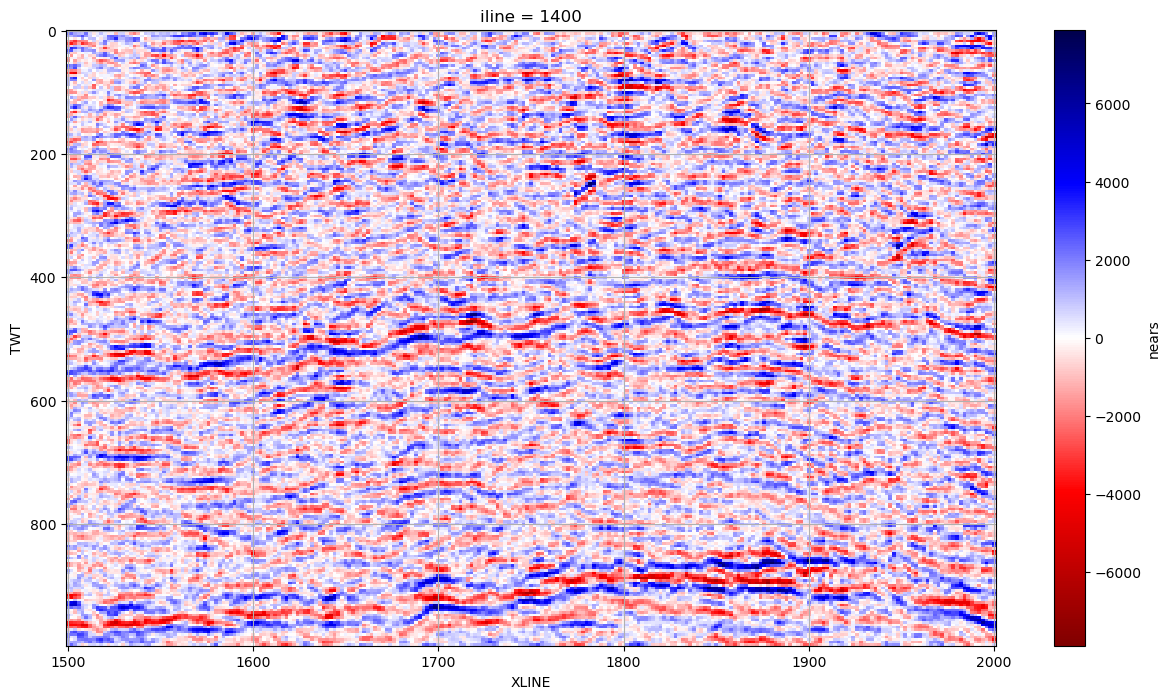

In [12]:
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 8))
iline_sel = 1400
vol.nears.transpose("samples", "iline", "xline", transpose_coords=True).sel(
    iline=iline_sel
).plot(yincrease=False, cmap="seismic_r")
plt.grid("grey")
plt.ylabel("TWT")
plt.xlabel("XLINE")

Text(0.5, 0, 'XLINE')

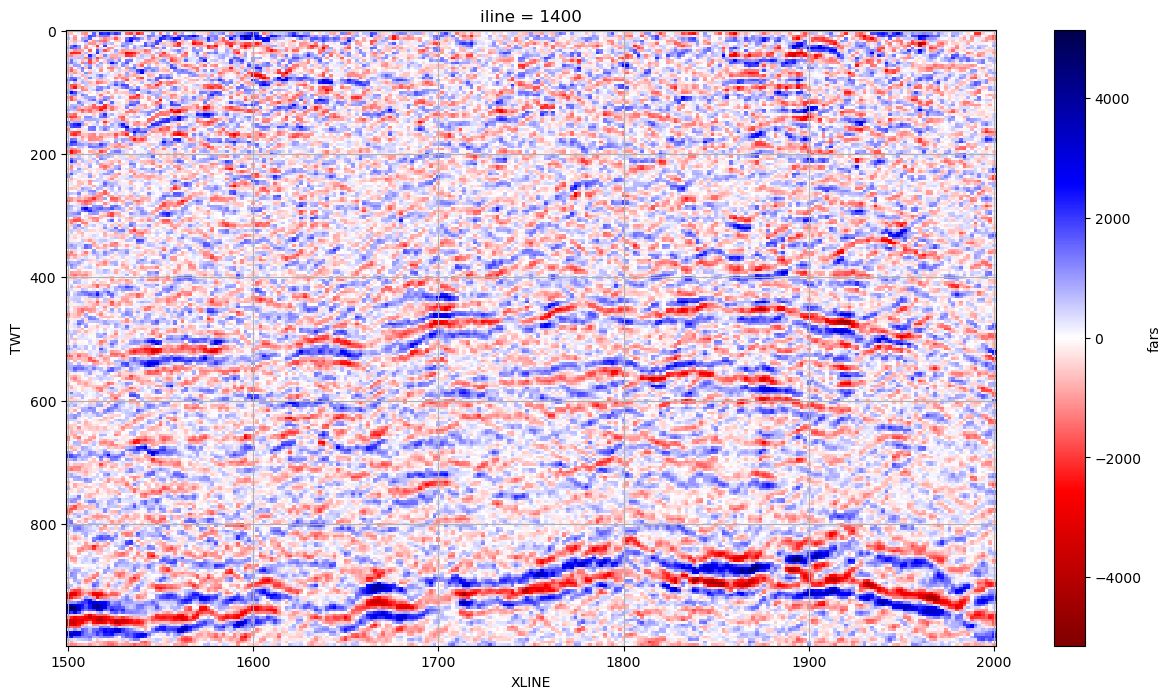

In [13]:
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 8))
iline_sel = 1400
vol.fars.transpose("samples", "iline", "xline", transpose_coords=True).sel(
    iline=iline_sel
).plot(yincrease=False, cmap="seismic_r")
plt.grid("grey")
plt.ylabel("TWT")
plt.xlabel("XLINE")

Text(0, 0.5, 'ILINE')

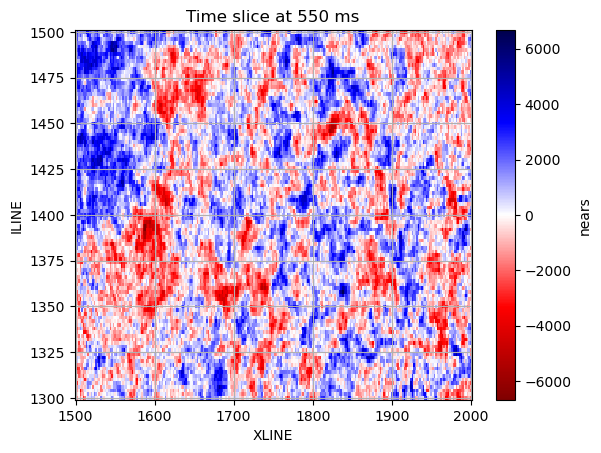

In [14]:
time_sel = 550
vol.nears.sel(samples=time_sel, method="nearest").plot(cmap="seismic_r")
plt.title(f"Time slice at {time_sel} ms")
plt.grid(True)
plt.xlabel("XLINE")
plt.ylabel("ILINE")

Text(0, 0.5, 'ILINE')

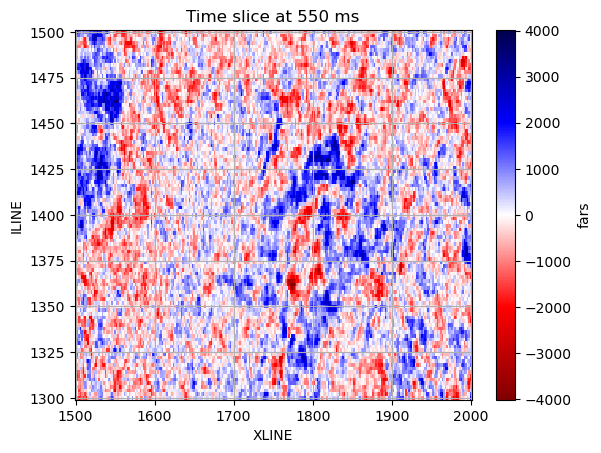

In [15]:
time_sel = 550
vol.fars.sel(samples=time_sel, method="nearest").plot(cmap="seismic_r")
plt.title(f"Time slice at {time_sel} ms")
plt.grid(True)
plt.xlabel("XLINE")
plt.ylabel("ILINE")

In [16]:
hrz_file = pathlib.Path("Horizons/Top_Heimdal_subset.txt")
hrz = pd.read_csv(hrz_file, names=["inline", "crossline", "twt"], sep="\s+")
hrz.head()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/6n/1q5tw76s26d681wk41cg18pc0000gn/T/ipykernel_18834/2023197780.py:2: SyntaxWarning: invalid escape sequence '\s'
  hrz = pd.read_csv(hrz_file, names=["inline", "crossline", "twt"], sep="\s+")


,inline,crossline,twt
0,1300,1500,2084.9
1,1300,1502,2084.6
2,1300,1504,2085.7
3,1300,1506,2085.0
4,1300,1508,2084.2


In [17]:
cp = nears.segysak.calc_corner_points()
corners = np.array(cp)
corners

array([[ 420414, 6506366],
       [ 424063, 6511446],
       [ 421918, 6512801],
       [ 418258, 6507738],
       [ 420414, 6506366]])

In [18]:
from scipy.interpolate import griddata

xi = np.linspace(hrz.cdp_x.min(), hrz.cdp_x.max(), 250)
yi = np.linspace(hrz.cdp_y.min(), hrz.cdp_y.max(), 250)
X, Y = np.meshgrid(xi, yi)
Z = griddata((hrz.cdp_x, hrz.cdp_y), hrz.twt, (X, Y), rescale=True)

AttributeError: 'DataFrame' object has no attribute 'cdp_x'

Near and far offset partial stacks: subcubes from full 3-d cubes.
segy format

* inline: 1300-1500, every 2
* xline: 1500-2000, every 2
* time: 1500-2500 ms
* total 25351 traces for each subcube.

* xline number stored in bytes 21-26.
* inline number (multiplied by 1000) stored in bytes 41-44.